## 14 신경망 심화모형 실습

### 14.1. CNN 실습

5주차에 수행했던 Olivetti Faces 데이터셋 분류를 CNN을 이용하여 수행하는 작업입니다.

In [ ]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from factor_analyzer.rotator import Rotator

# 딥러닝 라이브러리 (TensorFlow/Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 랜덤 시드 설정
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow 버전: {tf.__version__}")
print(f"사용 가능한 GPU: {len(tf.config.list_physical_devices('GPU'))}개")

TensorFlow 버전: 2.20.0
사용 가능한 GPU: 0개


Olivetti Faces 데이터셋:  

- 총 400개 이미지 (40명 × 각 10장)

- 이미지 크기: 64×64 픽셀 (흑백)

- 클래스 : 40명의 인물 ID

In [3]:
# Olivetti Faces 데이터 로딩
faces = fetch_olivetti_faces()
X = faces.data  # 400개 이미지 × 4096개 픽셀(64*64 해상도를 1차원으로 변환한 값)
y = faces.target  # 40명의 사람 ID (0-39)

print(f"데이터 형태: {X.shape}")
print(f"이미지 수: {X.shape[0]}")
print(f"픽셀 수: {X.shape[1]}")
print(f"클래스 수: {len(np.unique(y))}")
print(f"\n픽셀 값 범위: [{X.min():.4f}, {X.max():.4f}]")

데이터 형태: (400, 4096)
이미지 수: 400
픽셀 수: 4096
클래스 수: 40

픽셀 값 범위: [0.0000, 1.0000]


In [5]:
# 데이터 전처리
## 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Train/Test 분할 : 각 클래스의 비율을 유지하기 위해 stratify 인자값을 주었습니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"훈련 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")

훈련 데이터 크기: (280, 4096)
테스트 데이터 크기: (120, 4096)
훈련 클래스 분포: [7 7 7 7 7]... (처음 5개만)
테스트 클래스 분포: [3 3 3 3 3]... (처음 5개만)


5주차 실습파일에서 수행했던 PCA, FA 분석을 수행합니다.

In [65]:
# PCA
pca_full = PCA()
pca_full.fit(X_train)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

# PCA 변환
pca_90 = PCA(n_components=n_components_90, random_state=42)
X_train_pca = pca_90.fit_transform(X_train)
X_test_pca = pca_90.transform(X_test)

print(f"PCA 변환 후 shape: {X_train_pca.shape}")

PCA 변환 후 shape: (280, 59)


In [66]:
# FA
## 5주차에 사용했던 인자값(50개)을 그대로 사용하겠습니다.
fa_optimal = FactorAnalysis(n_components=50, random_state=42)
X_train_fa = fa_optimal.fit_transform(X_train)
X_test_fa = fa_optimal.transform(X_test)

print(f"FA 변환 후 shape: {X_train_fa.shape}")

FA 변환 후 shape: (280, 50)


In [67]:
# Varimax 회전
factor_loadings = fa_optimal.components_.T
rotator = Rotator(method='varimax')
rotated_loadings = rotator.fit_transform(factor_loadings)
rotation_matrix = rotator.rotation_

X_train_fa_rotated = X_train_fa @ rotation_matrix
X_test_fa_rotated = X_test_fa @ rotation_matrix

print(f"FA + Varimax 변환 후 shape: {X_train_fa_rotated.shape}")

FA + Varimax 변환 후 shape: (280, 50)


다음으로 CNN을 모형을 적합합니다.

In [ ]:
# CNN 입력에 맞게 reshape : CNN은 이미지의 원래 입력차원에 맞는 (가로해상도 * 세로해상도 * RGB채널수) 차원의 데이터를 받습니다.
X_train_cnn = X_train.reshape(-1, 64, 64, 1)
X_test_cnn = X_test.reshape(-1, 64, 64, 1)

# 레이블 원-핫 인코딩
y_train_onehot = to_categorical(y_train, 40)
y_test_onehot = to_categorical(y_test, 40)

print(f"CNN 입력 shape (훈련): {X_train_cnn.shape}")
print(f"CNN 입력 shape (테스트): {X_test_cnn.shape}")
print(f"레이블 shape: {y_train_onehot.shape}")

CNN 입력 shape (훈련): (280, 64, 64, 1)
CNN 입력 shape (테스트): (120, 64, 64, 1)
레이블 shape: (280, 40)


In [ ]:
def create_cnn_model():
    model = models.Sequential([
        # 첫 번째 합성곱 블록
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1), name='conv1'), # CNN층 / 커널 개수 32개, 커널 크기 3x3
        layers.MaxPooling2D((2, 2), name='pool1'), # 풀링층 / 풀링 크기 2x2
        
        # 두 번째 합성곱 블록
        layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        
        # 세 번째 합성곱 블록 (더 깊은 특징 추출)
        layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
        layers.MaxPooling2D((2, 2), name='pool3'),
        
        # Flatten: 2D → 1D
        layers.Flatten(name='flatten'),
        
        # 완전 연결층
        layers.Dense(256, activation='relu', name='fc1'), # 노드 256개로 구성된 바닐라NN 구조의 은닉층
        layers.Dropout(0.5, name='dropout'),
        
        # 출력층 (40명 분류)
        layers.Dense(40, activation='softmax', name='output') # 40개의 보기 중에서 하나를 고르는 문제로, softmax 출력층 40개로 구성됩니다. 
    ])
    
    return model

# 모델 생성
cnn_model = create_cnn_model()

# 모델 컴파일
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 구조 출력
cnn_model.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/qlab/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282,856 (4.89 MB)

 Trainable params: 1,282,856 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# CNN 학습
## 조기종료 설정
## train/valid 데이터를 비교해서 valid 데이터를 적합한 효율에서 개선이 없으면 학습을 중단하는 옵션입니다.
## 학습 epoch를 느슨하게 설정하기 때문에 학습 시간을 단축하기 위해서 꼭 필요한 옵션입니다.
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## 학습
history = cnn_model.fit(
    X_train_cnn, y_train_onehot,
    epochs=50,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stopping],
    verbose=1 # 이 옵션을 1로 두면 학습 과정이 출력됩니다.
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 674ms/step - accuracy: 0.0378 - loss: 3.7041 - val_accuracy: 0.1429 - val_loss: 3.5586
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 674ms/step - accuracy: 0.0378 - loss: 3.7041 - val_accuracy: 0.1429 - val_loss: 3.5586
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.1807 - loss: 3.3712 - val_accuracy: 0.0952 - val_loss: 3.3659
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.1807 - loss: 3.3712 - val_accuracy: 0.0952 - val_loss: 3.3659
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.2647 - loss: 2.8403 - val_accuracy: 0.2143 - val_loss: 2.6971
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.2647 - loss: 2.8403 - val_accuracy: 0.2143 - val_loss: 2.6971
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.4286 - loss: 2.0466 - val_accuracy: 0.5238 - val_loss: 1.9427
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.4286 - loss: 2.0466 - val_accuracy: 0.5238 - val_los

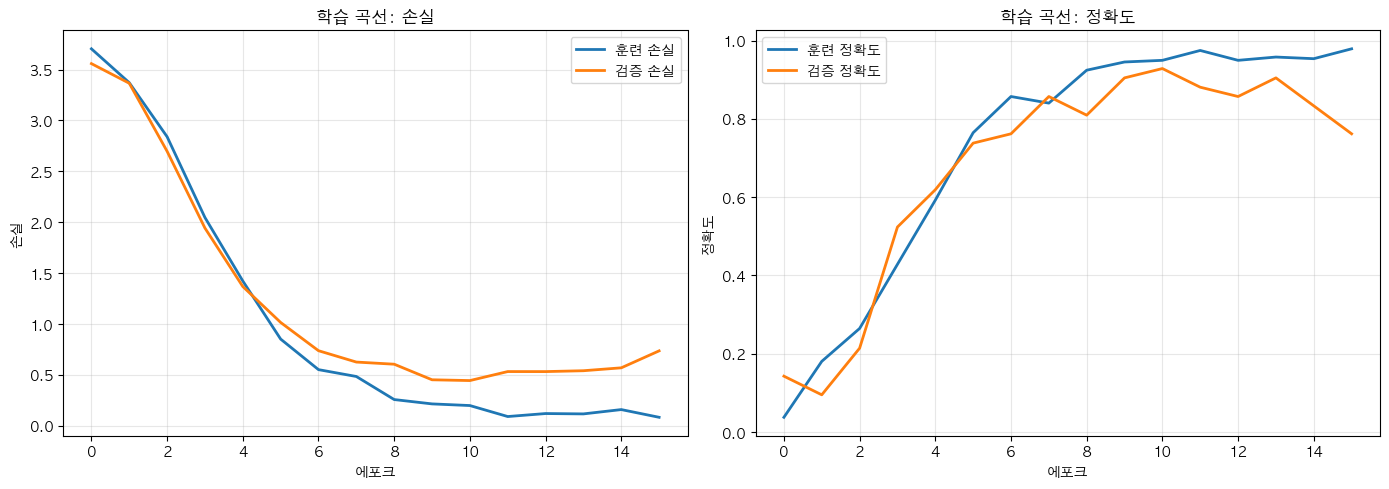

In [71]:
# 분석 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

## 손실 함수
axes[0].plot(history.history['loss'], label='훈련 손실', linewidth=2)
axes[0].plot(history.history['val_loss'], label='검증 손실', linewidth=2)
axes[0].set_xlabel('에포크')
axes[0].set_ylabel('손실')
axes[0].set_title('학습 곡선: 손실')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

## 정확도
axes[1].plot(history.history['accuracy'], label='훈련 정확도', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='검증 정확도', linewidth=2)
axes[1].set_xlabel('에포크')
axes[1].set_ylabel('정확도')
axes[1].set_title('학습 곡선: 정확도')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [72]:
# 테스트 데이터 평가
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test_onehot, verbose=0)
print(f"CNN 테스트 정확도: {test_accuracy:.4f}")

CNN 테스트 정확도: 0.9167


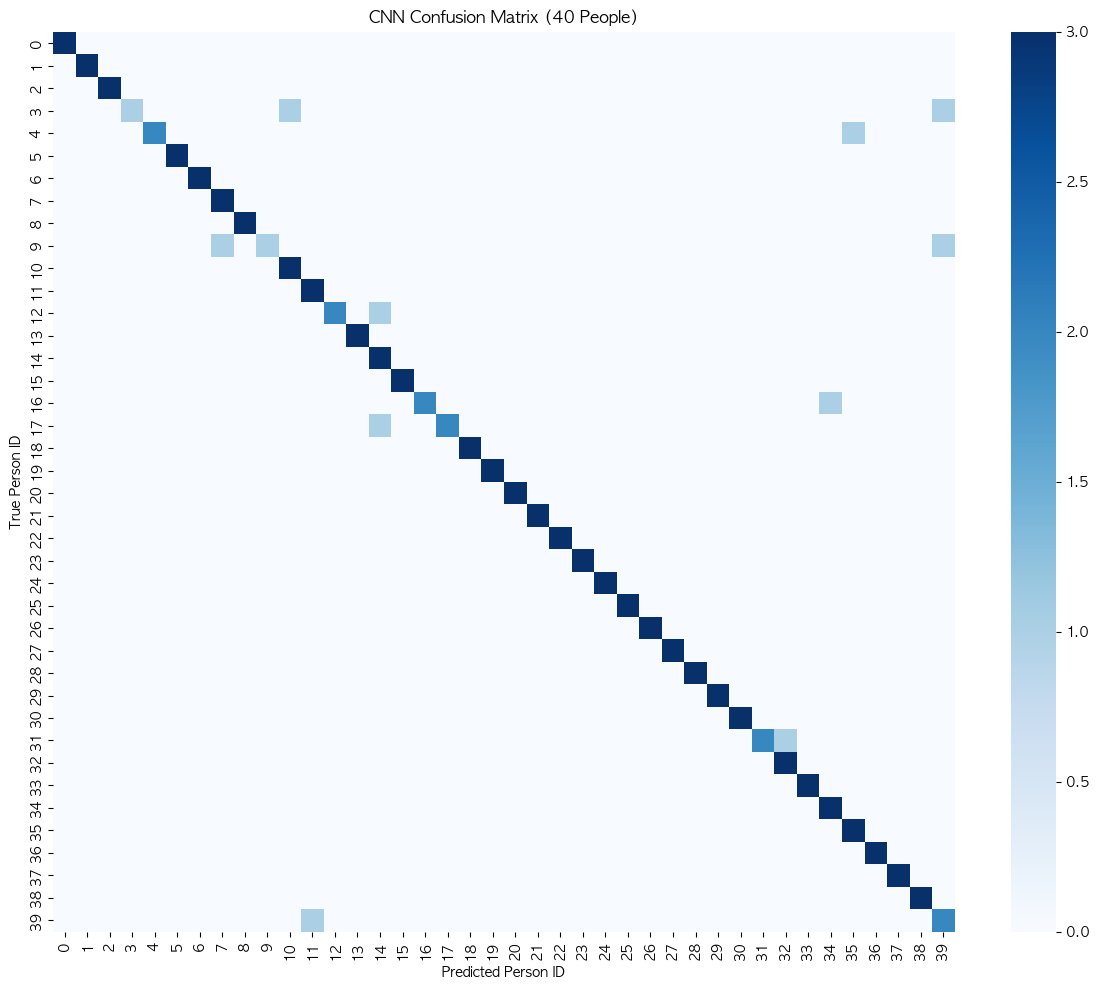


CNN Classification Accuracy: 0.9167


In [ ]:
# CNN 예측
y_pred_cnn_prob = cnn_model.predict(X_test_cnn, verbose=0)
y_pred_cnn = np.argmax(y_pred_cnn_prob, axis=1)

cm = confusion_matrix(y_test, y_pred_cnn)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Person ID')
plt.ylabel('True Person ID')
plt.title('CNN Confusion Matrix (40 People)')
plt.tight_layout()
plt.show()

print(f"\nCNN Classification Accuracy: {(y_pred_cnn == y_test).mean():.4f}")

In [74]:
# PCA, FA 변환 데이터를 기반으로 생성한 RandomForest 분류기 vs. CNN 비교
from sklearn.metrics import accuracy_score

# 1. Original (표준화된 원본 데이터)
rf_original = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_original.fit(X_train, y_train)
y_pred_original = rf_original.predict(X_test)
acc_original = accuracy_score(y_test, y_pred_original)

# 2. PCA
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_pca.fit(X_train_pca, y_train)
y_pred_pca = rf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

# 3. FA
rf_fa_rotated = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_fa_rotated.fit(X_train_fa_rotated, y_train)
y_pred_fa_rotated = rf_fa_rotated.predict(X_test_fa_rotated)
acc_fa_rotated = accuracy_score(y_test, y_pred_fa_rotated)

# 4. CNN (이미 계산됨)
acc_cnn = (y_pred_cnn == y_test).mean()

print("="*60)
print("RandomForest Classification Results (PCA/FA/Original)")
print("="*60)
print(f"1. Original (4096 dims)    : {acc_original:.4f}")
print(f"2. PCA ({X_train_pca.shape[1]} components)       : {acc_pca:.4f}")
print(f"3. FA ({X_train_fa_rotated.shape[1]} factors): {acc_fa_rotated:.4f}")
print(f"4. CNN (Deep Learning)     : {acc_cnn:.4f}")
print("="*60)

RandomForest Classification Results (PCA/FA/Original)
1. Original (4096 dims)    : 0.9333
2. PCA (59 components)       : 0.9417
3. FA (50 factors): 0.9583
4. CNN (Deep Learning)     : 0.9167


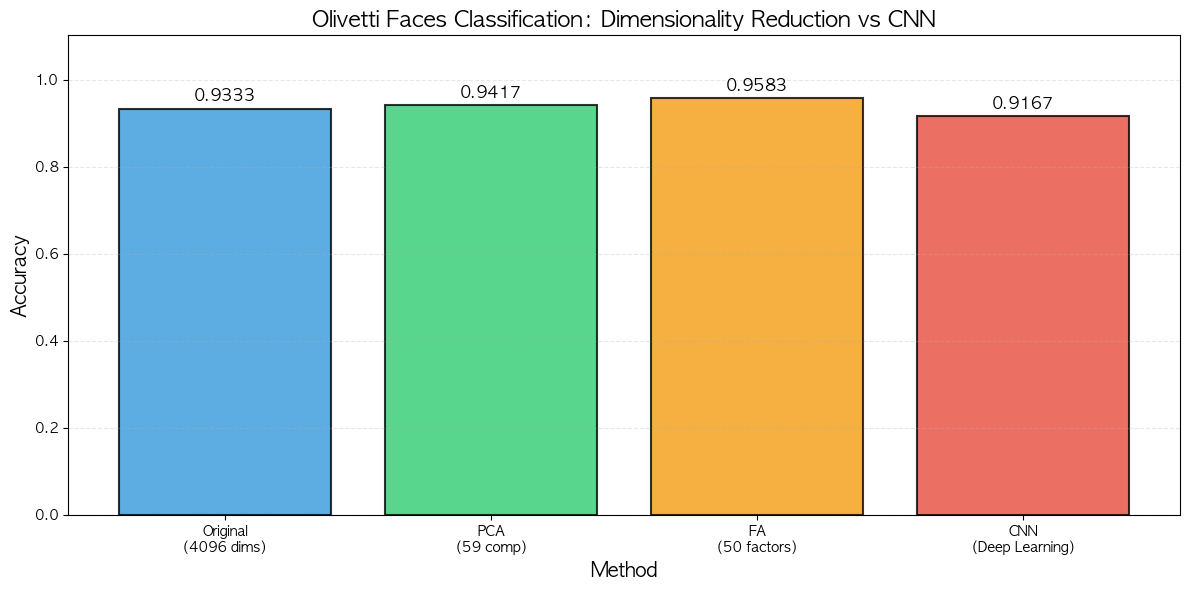

In [77]:
# 시각화: 5가지 방법 비교
methods = ['Original\n(4096 dims)', f'PCA\n({X_train_pca.shape[1]} comp)', 
           f'FA\n({X_train_fa_rotated.shape[1]} factors)', 
           'CNN\n(Deep Learning)']
accuracies = [acc_original, acc_pca, acc_fa_rotated, acc_cnn]

plt.figure(figsize=(12, 6))
bars = plt.bar(methods, accuracies, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'], 
               edgecolor='black', linewidth=1.5, alpha=0.8)

# 막대 위에 정확도 표시
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('Method', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.title('Olivetti Faces Classification: Dimensionality Reduction vs CNN', fontsize=16, fontweight='bold')
plt.ylim([0, max(accuracies) * 1.15])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

Conv1 가중치 shape: (3, 3, 1, 32)


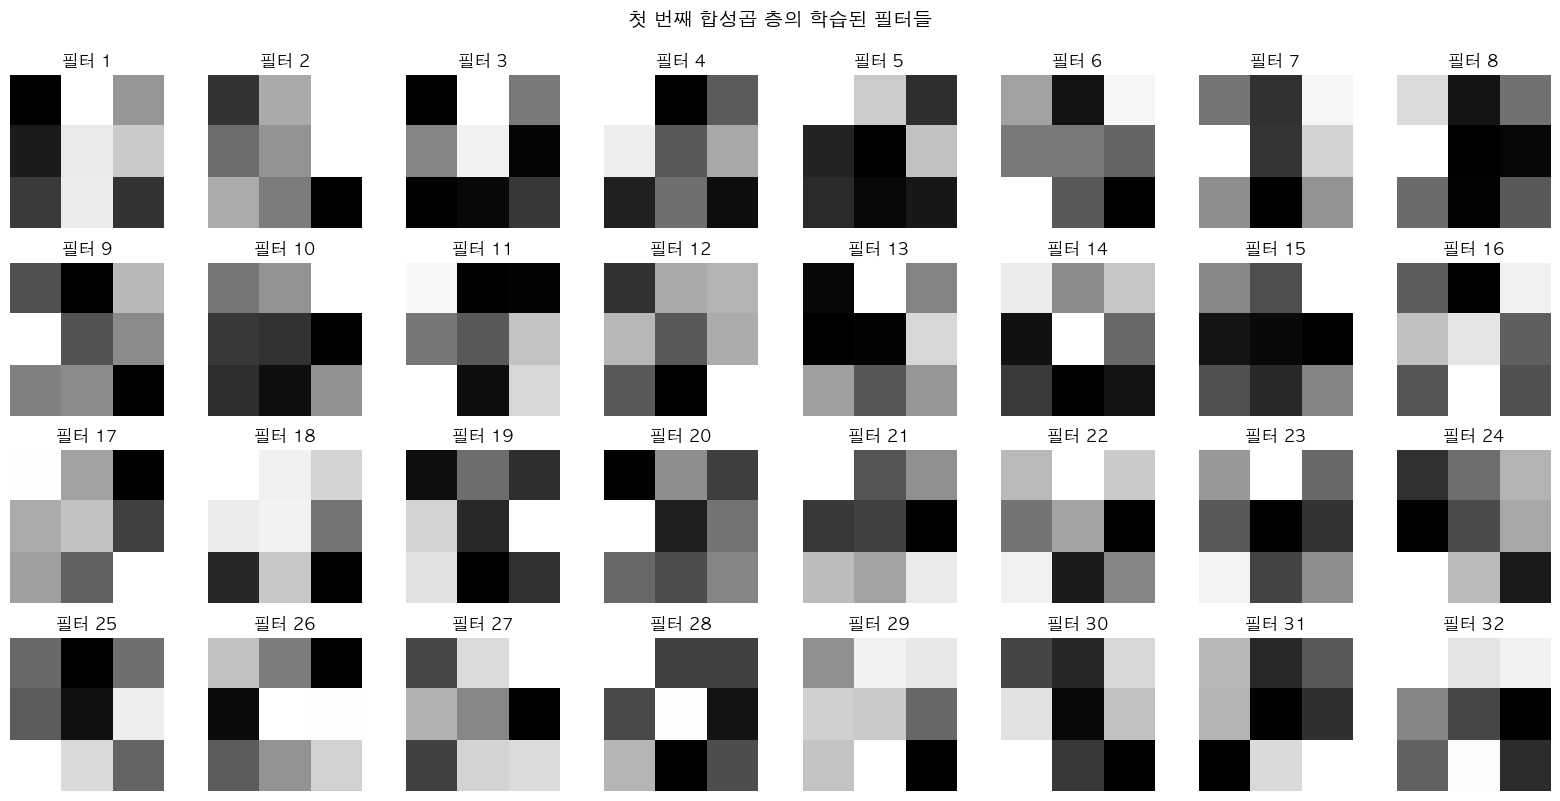

In [78]:
# 첫 번째 Conv 층의 가중치 추출
conv1_weights = cnn_model.get_layer('conv1').get_weights()[0]
print(f"Conv1 가중치 shape: {conv1_weights.shape}")  # (3, 3, 1, 32)

# 32개 필터 중 일부 시각화
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.ravel()

for i in range(32):
    # (3, 3, 1, 32) → (3, 3)
    filter_img = conv1_weights[:, :, 0, i]
    axes[i].imshow(filter_img, cmap='gray')
    axes[i].set_title(f'필터 {i+1}')
    axes[i].axis('off')

plt.suptitle('첫 번째 합성곱 층의 학습된 필터들', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

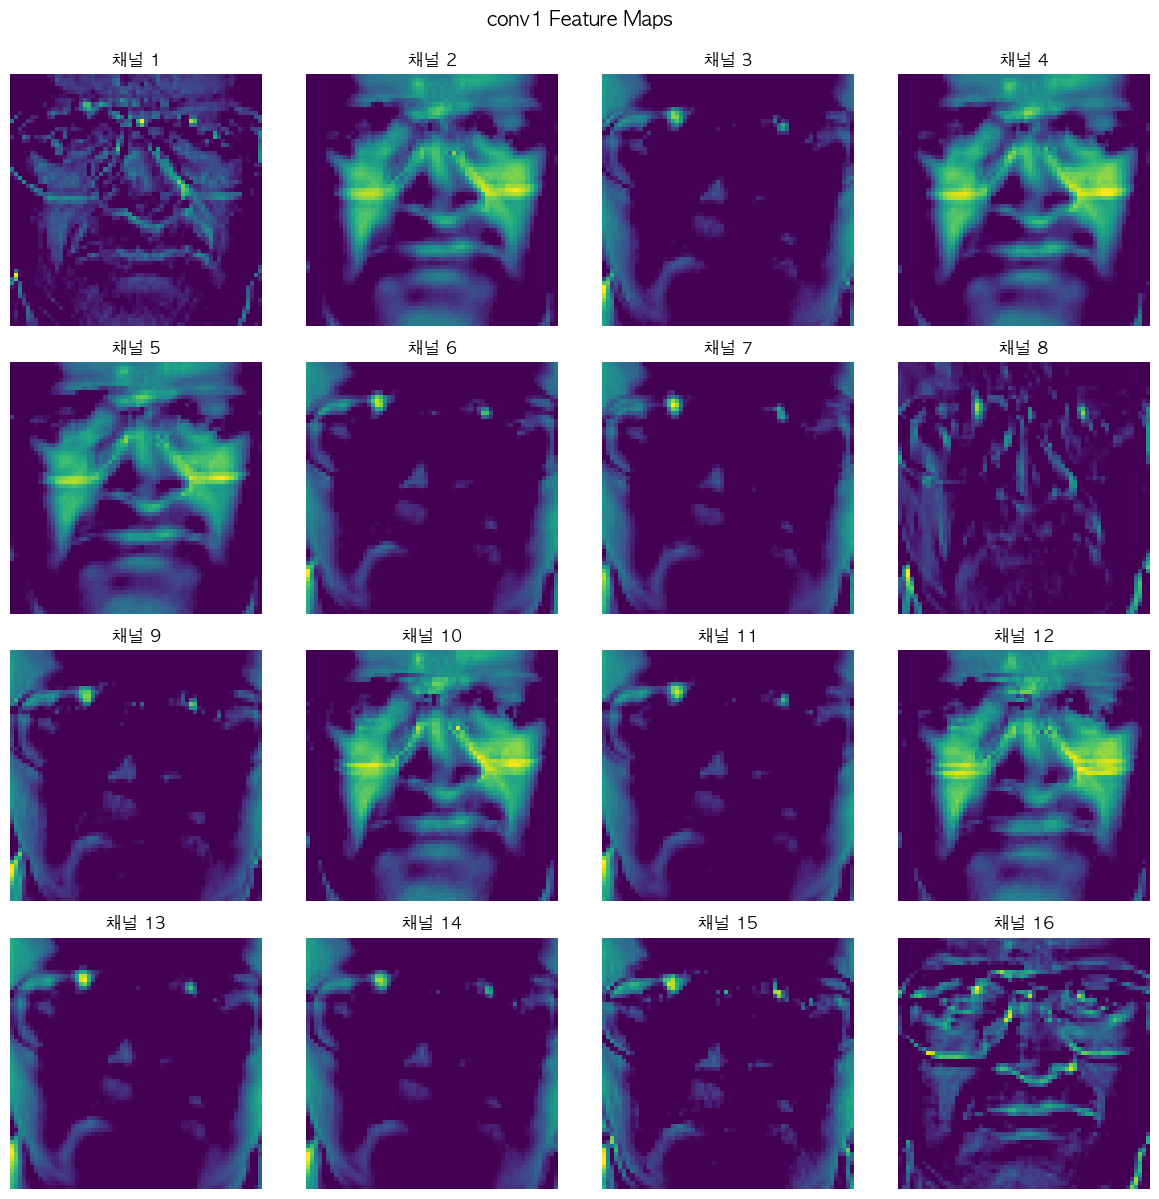

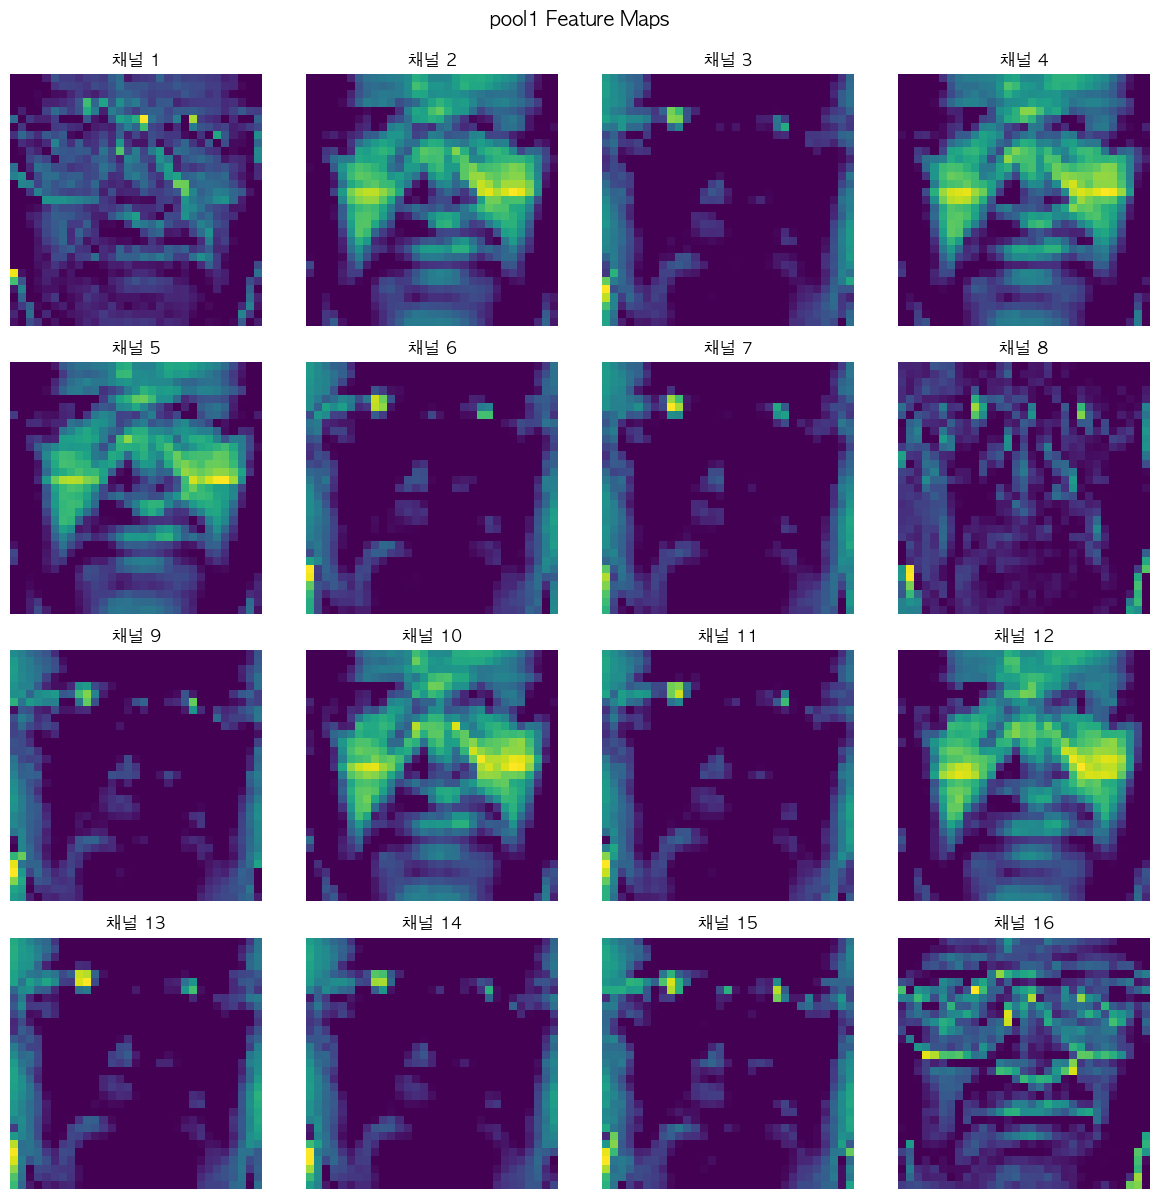

In [79]:
# Conv1 feature maps 시각화 (32개 중 16개만)
layer_names = ['conv1', 'pool1', 'conv2', 'pool2']

for layer_name, activation in zip(layer_names[:2], activations[:2]):
    n_features = min(16, activation.shape[-1])
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()
    
    for i in range(n_features):
        axes[i].imshow(activation[0, :, :, i], cmap='viridis')
        axes[i].set_title(f'채널 {i+1}')
        axes[i].axis('off')
    
    plt.suptitle(f'{layer_name} Feature Maps', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()

### 14.2. RNN/LSTM/GRU 실습

일일 최저 기온 데이터를 이용하여 미래 기온을 예측하는 예제코드입니다.

Melbourne Daily Minimum Temperatures 데이터셋 : 1981-1990년까지(3,650일) 멜버른의 일일 최저기온 기록 데이터

In [80]:
# 데이터 로딩
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'

# pandas로 직접 읽기
df_temp = pd.read_csv(url)
data = df_temp['Temp'].values.astype(float)
dates = pd.to_datetime(df_temp['Date'])

print(f"데이터 shape: {data.shape}")
print(f"데이터 기간: {dates.min()} ~ {dates.max()}")
print(f"데이터 범위: [{data.min():.2f}°C, {data.max():.2f}°C]")
print(f"평균 기온: {data.mean():.2f}°C")

데이터 shape: (3650,)
데이터 기간: 1981-01-01 00:00:00 ~ 1990-12-31 00:00:00
데이터 범위: [0.00°C, 26.30°C]
평균 기온: 11.18°C


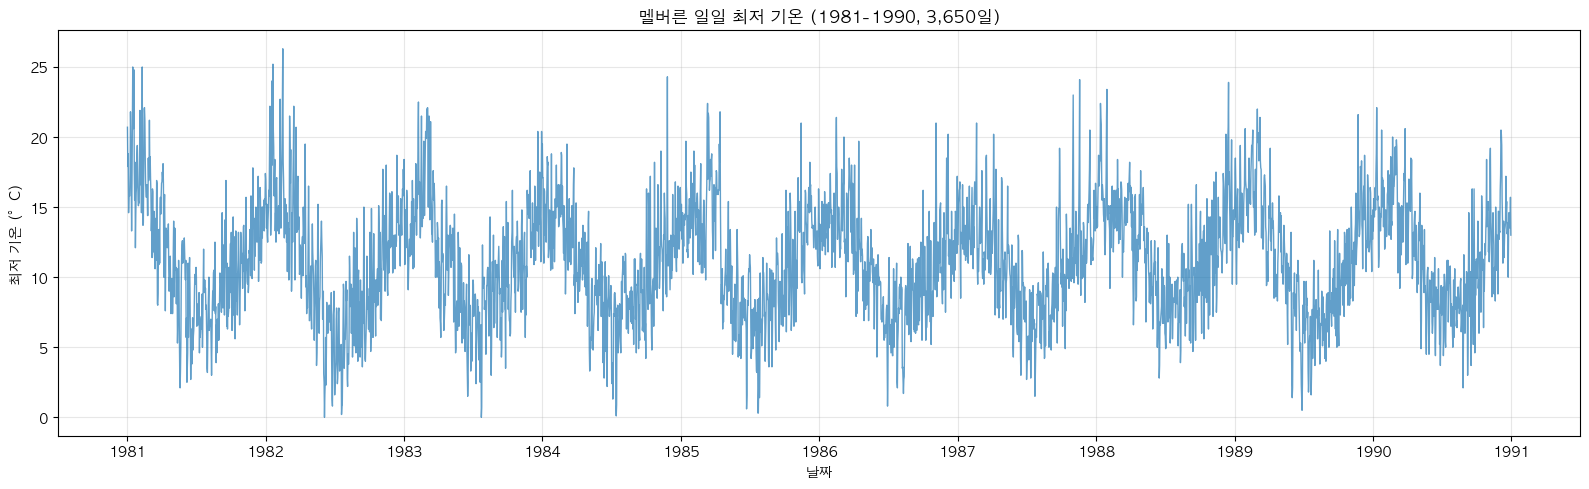

In [81]:
# 시각화 탐색
plt.figure(figsize=(16, 5))
plt.plot(dates, data, linewidth=1, alpha=0.7)
plt.xlabel('날짜')
plt.ylabel('최저 기온 (°C)')
plt.title('멜버른 일일 최저 기온 (1981-1990, 3,650일)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 데이터 전처리
## 정규화
scaler_ts = StandardScaler()
data_scaled = scaler_ts.fit_transform(data.reshape(-1, 1)).flatten()

## 시퀀스 데이터 생성 함수 : 과거 n일 데이터를 사용해 다음 날 예측하는 작업을 수행하기 위해 데이터를 변환합니다.
def create_sequences(data, seq_length):
    """
    시계열 데이터를 입력-출력 쌍으로 변환
    예: seq_length=30이면 과거 30일 데이터로 다음 날 예측
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

## 시퀀스 길이 설정 (과거 30일 데이터로 다음 날 예측)
SEQ_LENGTH = 30

X_seq, y_seq = create_sequences(data_scaled, SEQ_LENGTH)

print(f"시퀀스 데이터 shape: {X_seq.shape}")
print(f"타겟 데이터 shape: {y_seq.shape}")
print(f"전체 샘플 수: {len(X_seq)}")

## Train/Test 분할 : 시계열 데이터는 분할 비율에 따라 훈련데이터를 앞부분으로 사용합니다.
train_size = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
y_train_seq, y_test_seq = y_seq[:train_size], y_seq[train_size:]

print(f"\n훈련 샘플: {len(X_train_seq)}개")
print(f"테스트 샘플: {len(X_test_seq)}개")

## LSTM 입력에 맞게 reshape : LSTM은 (samples, timesteps, features) 차원의 데이터를 받습니다.
### samples : 모형에서 처리할 전체 데이터의 수
### timesteps : RNN 노드에서 참고할 과거 시점의 수 / 이 예제에서는 31일차 기온이 1~30일 기온의 영향을 받는 것으로 설정했습니다.
### features : 시계열 데이터의 수 / 데이터에 따라 (주가, 거래량)처럼 2개 이상의 시계열을 동시에 처리하는 경우도 있습니다.
X_train_lstm = X_train_seq.reshape(-1, SEQ_LENGTH, 1)
X_test_lstm = X_test_seq.reshape(-1, SEQ_LENGTH, 1)

print(f"\nLSTM 입력 shape (훈련): {X_train_lstm.shape}")
print(f"LSTM 입력 shape (테스트): {X_test_lstm.shape}")

시퀀스 데이터 shape: (3620, 30)
타겟 데이터 shape: (3620,)
전체 샘플 수: 3620

훈련 샘플: 2896개
테스트 샘플: 724개

LSTM 입력 shape (훈련): (2896, 30, 1)
LSTM 입력 shape (테스트): (724, 30, 1)


In [ ]:
# RNN 모델 설계
rnn_model = models.Sequential([
    layers.SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 1), name='rnn1'), # RNN 노드 50개로 이루어진 은닉층
    layers.SimpleRNN(50, activation='relu', name='rnn2'), # RNN 노드 50개로 이루어진 은닉층
    layers.Dense(1, name='output') # 출력층
    ])
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
rnn_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn1 (SimpleRNN)                │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn2 (SimpleRNN)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,701 (30.08 KB)

 Trainable params: 7,701 (30.08 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# RNN 학습
## 조기종료 설정
early_stopping_rnn = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

## 학습
history_rnn = rnn_model.fit(
    X_train_lstm, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping_rnn],
    verbose=1
)

print("학습 완료!")
print(f"최종 훈련 손실: {history_rnn.history['loss'][-1]:.4f}")
print(f"최종 검증 손실: {history_rnn.history['val_loss'][-1]:.4f}")

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0942 - mae: 0.2406 - val_loss: 0.5889 - val_mae: 0.5979
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0942 - mae: 0.2406 - val_loss: 0.5889 - val_mae: 0.5979
Epoch 2/100
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0968 - mae: 0.2451 - val_loss: 0.5956 - val_mae: 0.5973
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0968 - mae: 0.2451 - val_loss: 0.5956 - val_mae: 0.5973
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.1000 - mae: 0.2489 - val_loss: 0.6125 - val_mae: 0.6114
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.1000 - mae: 0.2489 - val_loss: 0.6125 - val_mae: 0.6114
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1054 - mae: 0.2579 - val_loss: 0.5971 - val_mae: 0.6005
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1054 - mae: 0.2579 - val_loss: 0.5971 - val_mae: 0.6005
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - lo

In [90]:
# LSTM 모델 설계
lstm_model = models.Sequential([
    layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 1), name='lstm1'),
    layers.LSTM(50, activation='relu', name='lstm2'),
    layers.Dense(1, name='output')
    ])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
lstm_model.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/qlab/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                    │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# LSTM 모델 학습
## 조기종료 설정
early_stopping_lstm = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

## 학습
print("LSTM 학습 중...")
history_lstm = lstm_model.fit(
    X_train_lstm, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping_lstm],
    verbose=0 # 이 인자값을 0으로 두면 학습 과정이 출력되지 않지만 매우 답답합니다.
)

print("학습 완료!")
print(f"최종 훈련 손실: {history_lstm.history['loss'][-1]:.4f}")
print(f"최종 검증 손실: {history_lstm.history['val_loss'][-1]:.4f}")

LSTM 학습 중...
학습 완료!
최종 훈련 손실: 0.3318
최종 검증 손실: 0.3704
학습 완료!
최종 훈련 손실: 0.3318
최종 검증 손실: 0.3704


In [92]:
# GRU 모델 설계
gru_model = models.Sequential([
    layers.GRU(50, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 1), name='gru1'), # GRU 노드 50개로 이루어진 은닉층
    layers.GRU(50, activation='relu', name='gru2'), # GRU 노드 50개로 이루어진 은닉층
    layers.Dense(1, name='output') # 출력층
    ])
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
gru_model.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/qlab/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru1 (GRU)                      │ (None, 30, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru2 (GRU)                      │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
# GRU 모델 학습
## 학습곡선의 변화를 보여드리기 위해서 GRU는 조기종료 설정을 하지 않았습니다. 조기종료 없이 verbose=0을 두시면 고구마 100개 답답함을 느끼실 수 있습니다.
# early_stopping_gru = keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True
# )

## 학습
history_gru = gru_model.fit(
    X_train_lstm, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    # callbacks=[early_stopping_gru],
    verbose=1
)

print("학습 완료!")
print(f"최종 훈련 손실: {history_gru.history['loss'][-1]:.4f}")
print(f"최종 검증 손실: {history_gru.history['val_loss'][-1]:.4f}")

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - loss: 0.5307 - mae: 0.5635 - val_loss: 0.4454 - val_mae: 0.5205
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - loss: 0.5307 - mae: 0.5635 - val_loss: 0.4454 - val_mae: 0.5205
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.4071 - mae: 0.4968 - val_loss: 0.4076 - val_mae: 0.5039
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.4071 - mae: 0.4968 - val_loss: 0.4076 - val_mae: 0.5039
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.3711 - mae: 0.4770 - val_loss: 0.3867 - val_mae: 0.4900
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.3711 - mae: 0.4770 - val_loss: 0.3867 - val_mae: 0.4900
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.3646 - mae: 0.4730 - val_loss: 0.3838 - val_mae: 0.4883
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.3646 - mae: 0.4730 - val_loss: 0.3838 - val_mae: 0.4883
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - 

In [98]:
# 모델별 예측 성능 비교
## 예측값 계산
y_pred_rnn = rnn_model.predict(X_test_lstm).flatten()
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
y_pred_gru = gru_model.predict(X_test_lstm).flatten()

## 역정규화 : 원래 스케일로 복원
y_test_original = scaler_ts.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
y_pred_rnn_original = scaler_ts.inverse_transform(y_pred_rnn.reshape(-1, 1)).flatten()
y_pred_lstm_original = scaler_ts.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_pred_gru_original = scaler_ts.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()

## 성능 지표 계산
def evaluate_timeseries(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

rnn_scores = evaluate_timeseries(y_test_original, y_pred_rnn_original, "Simple RNN")
lstm_scores = evaluate_timeseries(y_test_original, y_pred_lstm_original, "LSTM")
gru_scores = evaluate_timeseries(y_test_original, y_pred_gru_original, "GRU")

# 성능 비교표
comparison_df = pd.DataFrame({
    'Simple RNN': rnn_scores,
    'LSTM': lstm_scores,
    'GRU': gru_scores
})

print("\n모델 성능 비교:")
print(comparison_df)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

모델 성능 비교:
      Simple RNN      LSTM       GRU
RMSE    2.908925  2.182613  2.367675
MAE     2.297502  1.704512  1.858259
R2      0.496538  0.716564  0.666461

모델 성능 비교:
      Simple RNN      LSTM       GRU
RMSE    2.908925  2.182613  2.367675
MAE     2.297502  1.704512  1.858259
R2      0.496538  0.716564  0.666461


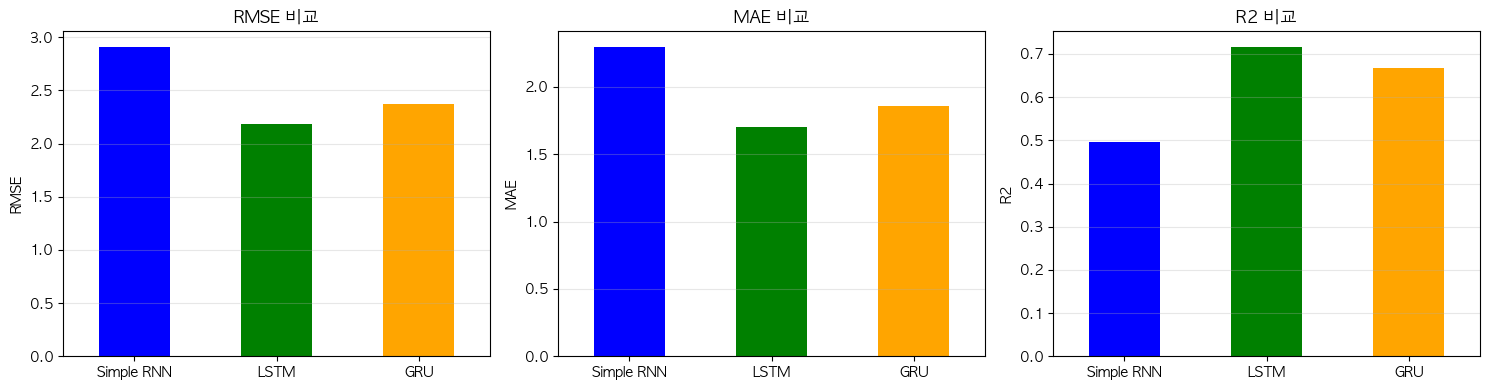

In [99]:
## 성능 비교 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, metric in enumerate(['RMSE', 'MAE', 'R2']):
    comparison_df.loc[metric].plot(kind='bar', ax=axes[i], color=['blue', 'green', 'orange'])
    axes[i].set_title(f'{metric} 비교')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('')
    axes[i].grid(True, alpha=0.3, axis='y')
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

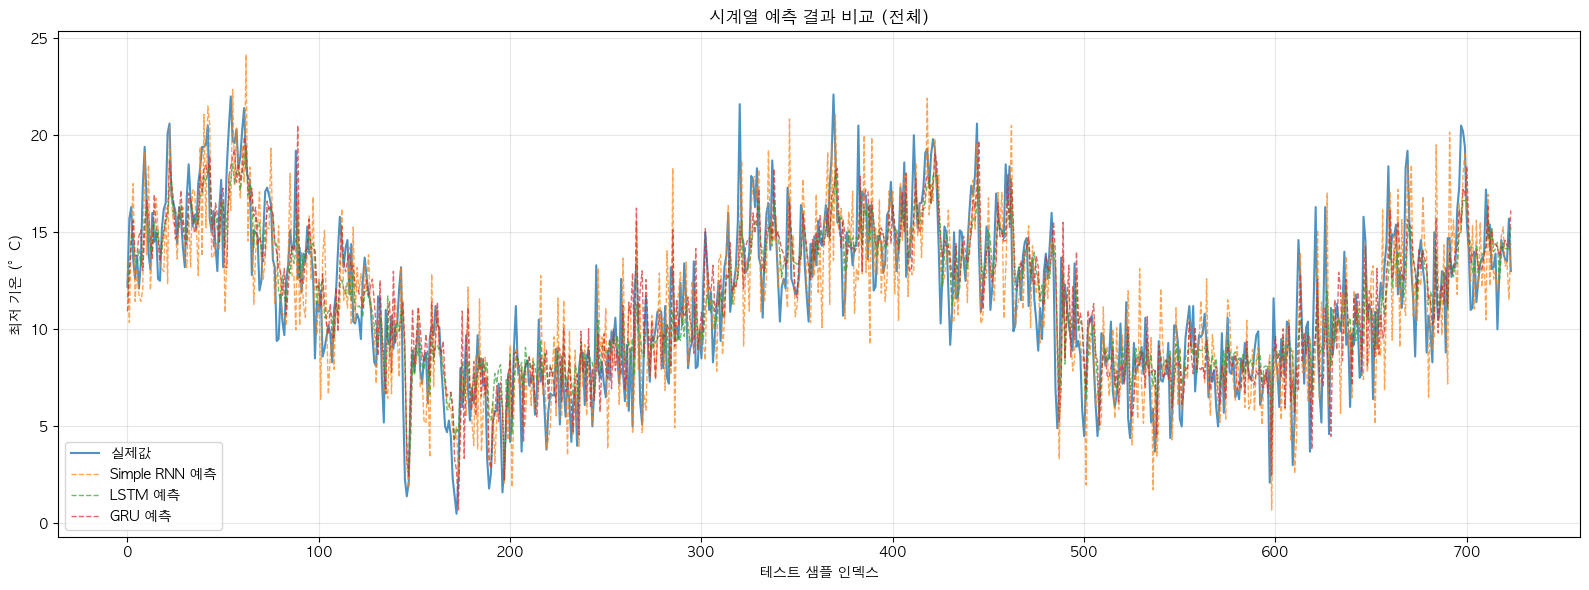

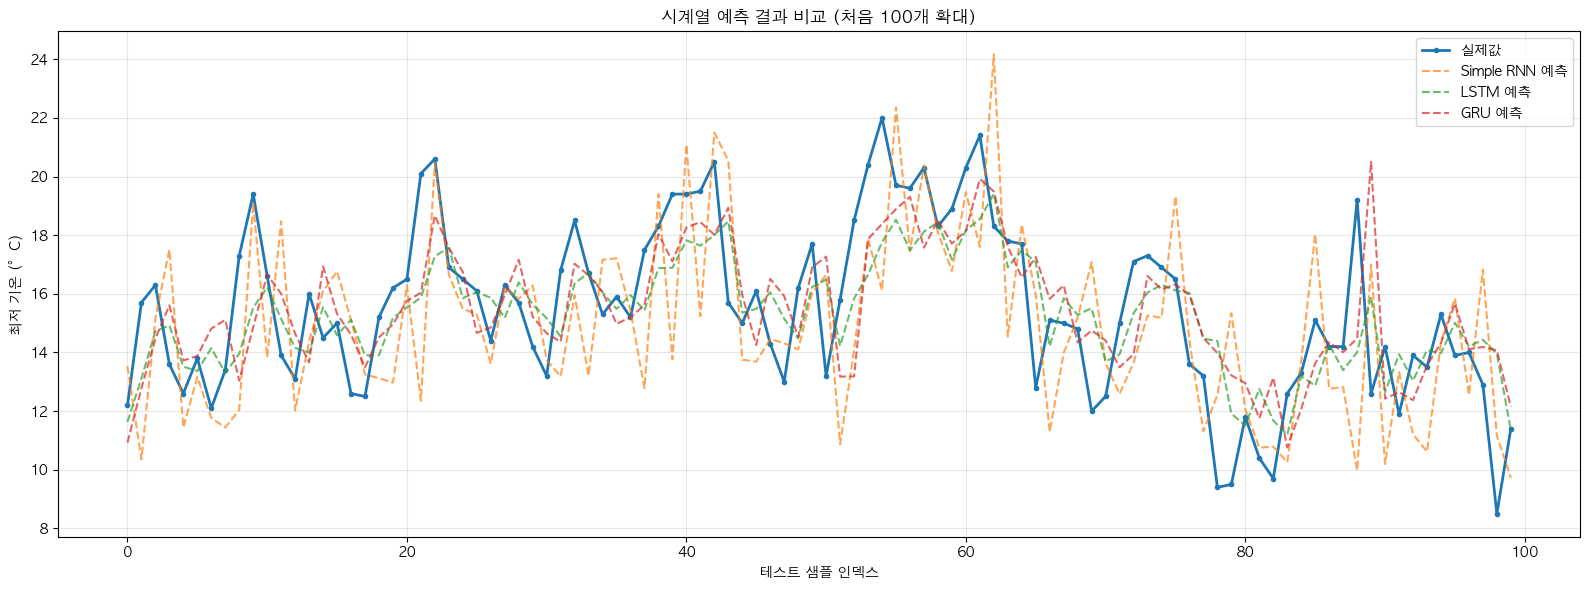

In [100]:
# 예측 결과 시각화 (전체 테스트 데이터)
plt.figure(figsize=(16, 6))

# 테스트 데이터의 시간 인덱스
test_indices = np.arange(len(y_test_seq))

plt.plot(test_indices, y_test_original, label='실제값', linewidth=1.5, alpha=0.8)
plt.plot(test_indices, y_pred_rnn_original, label='Simple RNN 예측', linewidth=1, linestyle='--', alpha=0.7)
plt.plot(test_indices, y_pred_lstm_original, label='LSTM 예측', linewidth=1, linestyle='--', alpha=0.7)
plt.plot(test_indices, y_pred_gru_original, label='GRU 예측', linewidth=1, linestyle='--', alpha=0.7)

plt.xlabel('테스트 샘플 인덱스')
plt.ylabel('최저 기온 (°C)')
plt.title('시계열 예측 결과 비교 (전체)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 처음 100개 샘플만 확대
plt.figure(figsize=(16, 6))
n_zoom = 100

plt.plot(test_indices[:n_zoom], y_test_original[:n_zoom], label='실제값', linewidth=2, marker='o', markersize=3)
plt.plot(test_indices[:n_zoom], y_pred_rnn_original[:n_zoom], label='Simple RNN 예측', linewidth=1.5, linestyle='--', alpha=0.7)
plt.plot(test_indices[:n_zoom], y_pred_lstm_original[:n_zoom], label='LSTM 예측', linewidth=1.5, linestyle='--', alpha=0.7)
plt.plot(test_indices[:n_zoom], y_pred_gru_original[:n_zoom], label='GRU 예측', linewidth=1.5, linestyle='--', alpha=0.7)

plt.xlabel('테스트 샘플 인덱스')
plt.ylabel('최저 기온 (°C)')
plt.title(f'시계열 예측 결과 비교 (처음 {n_zoom}개 확대)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

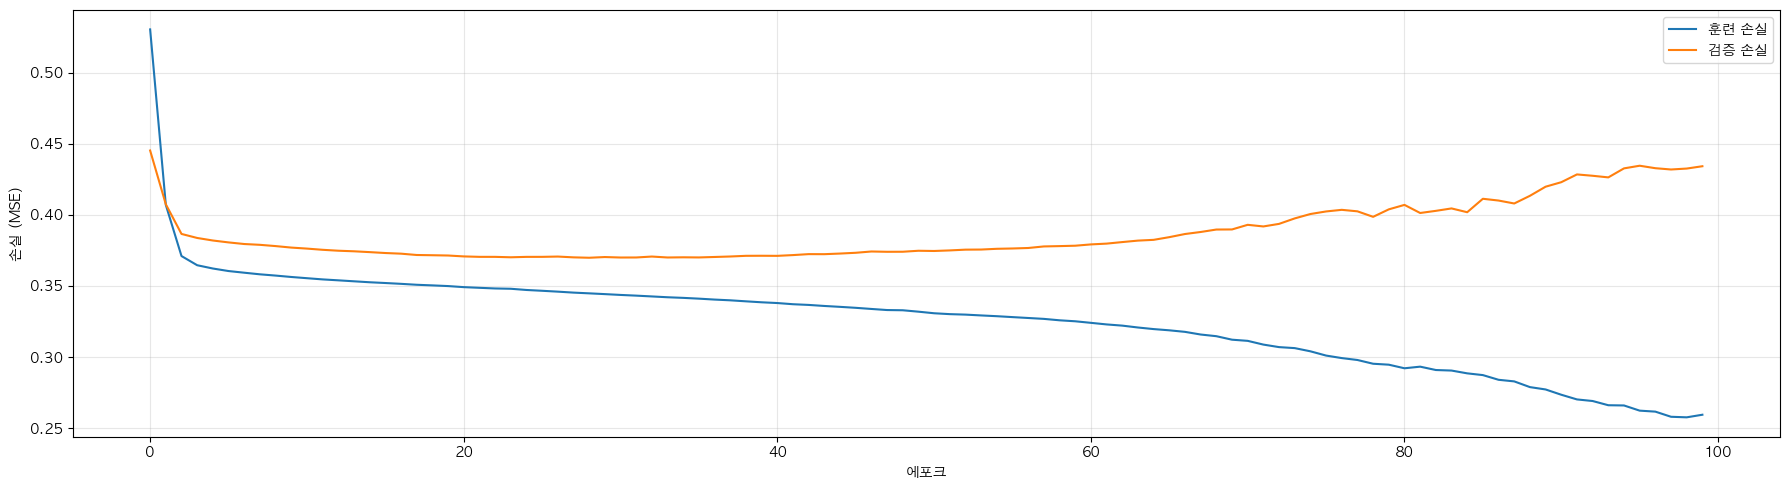

In [101]:
# GRU 모형의 학습 곡선
plt.figure(figsize=(18, 5))

plt.plot(history_gru.history['loss'], label='훈련 손실')
plt.plot(history_gru.history['val_loss'], label='검증 손실')
plt.xlabel('에포크')
plt.ylabel('손실 (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 14.3. Transformer 실습

Transformer 구조의 신경망에 BBC News 데이터셋을 학습하여 다음 단어를 예측하는 모델을 구축하는 예제입니다.

In [ ]:
# 라이브러리 로딩
import re
from collections import Counter

# BBC News 데이터셋 로딩 : 깃허브의 데이터셋을 이용합니다. 
df_news = pd.read_csv('https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv')

print(f"\n데이터셋 정보:")
print(f"전체 기사 수: {len(df_news)}")
print(f"카테고리: {df_news['category'].unique()}")
print(f"\n카테고리별 기사 수:")
print(df_news['category'].value_counts())

# 샘플 데이터 확인
print(f"\n첫 번째 기사 미리보기:")
print(f"카테고리: {df_news['category'][0]}")
print(f"내용: {df_news['text'][0][:200]}...")


데이터셋 정보:
전체 기사 수: 2225
카테고리: ['tech' 'business' 'sport' 'entertainment' 'politics']

카테고리별 기사 수:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

첫 번째 기사 미리보기:
카테고리: tech
내용: tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in...


In [132]:
# 텍스트 전처리 함수
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# 전체 기사를 사용합니다.
sampled_texts = df_news['text'].tolist()

# 각 문서를 전처리하여 단어 리스트로 변환
processed_docs = []
for text in sampled_texts:
    words = preprocess_text(text).split()
    if len(words) > 0:  # 빈 문서 제외
        processed_docs.append(words)

print(f"\n전처리 후 통계:")
print(f"총 문서 수: {len(processed_docs)}")
print(f"평균 문서 길이: {np.mean([len(doc) for doc in processed_docs]):.1f} 단어")
print(f"최소 문서 길이: {min([len(doc) for doc in processed_docs])} 단어")
print(f"최대 문서 길이: {max([len(doc) for doc in processed_docs])} 단어")



전처리 후 통계:
총 문서 수: 2225
평균 문서 길이: 382.3 단어
최소 문서 길이: 89 단어
최대 문서 길이: 4449 단어


In [133]:
# 단어 사전 생성
# 모든 문서의 단어를 수집하여 어휘 생성
all_words = [word for doc in processed_docs for word in doc]
word_counts = Counter(all_words)

# 모든 고유 단어를 어휘로 사용 (문서 수 제한으로 자연스럽게 어휘 크기 제한)
vocab = ['<PAD>', '<UNK>'] + list(word_counts.keys())
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

VOCAB_SIZE = len(vocab)
SEQ_LENGTH = 40  # 시퀀스 길이를 40으로 감소
MAX_DOC_WORDS = 500  # 각 문서에서 앞의 100개 단어만 사용

print(f"어휘 크기: {VOCAB_SIZE}")
print(f"시퀀스 길이: {SEQ_LENGTH}")
print(f"문서당 최대 단어 수: {MAX_DOC_WORDS}")

# 문서 단위로 시퀀스 생성 (각 문서당 1개 시퀀스만 생성)
def create_sequences_from_docs(docs, seq_length, max_doc_words, word_to_idx):
    sequences = []
    targets = []
    
    for doc in docs:
        # 각 문서의 앞 max_doc_words개 단어만 사용
        doc_subset = doc[:max_doc_words]
        
        # 문서 길이가 seq_length+1보다 작으면 건너뛰기
        if len(doc_subset) < seq_length + 1:
            continue
        
        # 각 문서에서 정확히 1개의 시퀀스만 생성 (앞 seq_length개 단어)
        seq = doc_subset[:seq_length]
        target = doc_subset[seq_length]
        
        # 단어를 인덱스로 변환 (모든 단어가 어휘에 있음)
        seq_idx = [word_to_idx[word] for word in seq]
        target_idx = word_to_idx[target]
        
        sequences.append(seq_idx)
        targets.append(target_idx)
    
    return np.array(sequences), np.array(targets)

X_transformer, y_transformer = create_sequences_from_docs(processed_docs, SEQ_LENGTH, MAX_DOC_WORDS, word_to_idx)

print(f"\n입력 시퀀스 shape: {X_transformer.shape}")
print(f"타겟 shape: {y_transformer.shape}")
print(f"총 시퀀스 수: {len(X_transformer)}")

if len(X_transformer) > 0:
    print(f"\n첫 번째 시퀀스 예시:")
    print(f"입력 (처음 5개 단어): {[idx_to_word[idx] for idx in X_transformer[0][:5]]}")
    print(f"타겟: {idx_to_word[y_transformer[0]]}")
else:
    print("\n경고: 생성된 시퀀스가 없습니다!")


어휘 크기: 30342
시퀀스 길이: 40
문서당 최대 단어 수: 500

입력 시퀀스 shape: (2225, 40)
타겟 shape: (2225,)
총 시퀀스 수: 2225

첫 번째 시퀀스 예시:
입력 (처음 5개 단어): ['tv', 'future', 'in', 'the', 'hands']
타겟: an


In [134]:
# Train/Test 분할
train_size_tf = int(0.9 * len(X_transformer))
X_train_tf = X_transformer[:train_size_tf]
X_test_tf = X_transformer[train_size_tf:]
y_train_tf = y_transformer[:train_size_tf]
y_test_tf = y_transformer[train_size_tf:]

print(f"훈련 데이터: {X_train_tf.shape}")
print(f"테스트 데이터: {X_test_tf.shape}")

훈련 데이터: (2002, 40)
테스트 데이터: (223, 40)


In [135]:
# Transformer 언어 모델 구축
def create_transformer_model():
    # 모델 파라미터 설정
    embed_dim = 64  # 임베딩 차원
    num_heads = 4   # Attention head 수
    ff_dim = 128    # Feed-forward 차원
    
    # 입력 레이어
    inputs = layers.Input(shape=(SEQ_LENGTH,))
    
    # 토큰 및 위치 임베딩
    token_emb = layers.Embedding(input_dim=VOCAB_SIZE, output_dim=embed_dim)(inputs)
    positions = tf.range(start=0, limit=SEQ_LENGTH, delta=1)
    pos_emb = layers.Embedding(input_dim=SEQ_LENGTH, output_dim=embed_dim)(positions)
    x = token_emb + pos_emb
    
    # 첫 번째 Transformer 블록
    attn_output1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn_output1 = layers.Dropout(0.1)(attn_output1)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output1)
    
    ffn_output1 = layers.Dense(ff_dim, activation="relu")(out1)
    ffn_output1 = layers.Dense(embed_dim)(ffn_output1)
    ffn_output1 = layers.Dropout(0.1)(ffn_output1)
    transformer1_out = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output1)
    
    # 두 번째 Transformer 블록
    attn_output2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(transformer1_out, transformer1_out)
    attn_output2 = layers.Dropout(0.1)(attn_output2)
    out2 = layers.LayerNormalization(epsilon=1e-6)(transformer1_out + attn_output2)
    
    ffn_output2 = layers.Dense(ff_dim, activation="relu")(out2)
    ffn_output2 = layers.Dense(embed_dim)(ffn_output2)
    ffn_output2 = layers.Dropout(0.1)(ffn_output2)
    transformer2_out = layers.LayerNormalization(epsilon=1e-6)(out2 + ffn_output2)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(transformer2_out)
    x = layers.Dropout(0.1)(x)
    
    # 출력층 (다음 단어 예측)
    outputs = layers.Dense(VOCAB_SIZE, activation='softmax')(x)
    
    # 모델 생성
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# 모델 생성
transformer_model = create_transformer_model()

# 모델 컴파일
transformer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 구조 출력
transformer_model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 40, 64)    │  1,941,888 │ input_layer_24[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 40, 64)    │          0 │ embedding_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 64)    │     66,368 │ add_15[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 40, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 40, 64)    │          0 │ add_15[0][0],     │
│                     │                   │            │ dropout_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 64)    │        128 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 40, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 40, 64)    │      8,256 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 40, 64)    │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 40, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 64)    │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 40, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 40, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 64)    │        128 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 40, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 40, 64)    │      8,256 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,080,518 (15.57 MB)

 Trainable params: 4,080,518 (15.57 MB)

 Non-trainable params: 0 (0.00 B)

In [136]:
# 모델 학습
## 조기종료 설정
early_stopping_transformer = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

## 학습
history_transformer = transformer_model.fit(
    X_train_tf, y_train_tf,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping_transformer],
    verbose=1
)

print("\n학습 완료!")
print(f"최종 훈련 손실: {history_transformer.history['loss'][-1]:.4f}")
print(f"최종 검증 손실: {history_transformer.history['val_loss'][-1]:.4f}")

Transformer 언어 모델 학습 중...
Epoch 1/50
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 274ms/step - accuracy: 0.0727 - loss: 9.2323 - val_accuracy: 0.0498 - val_loss: 8.0605
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 274ms/step - accuracy: 0.0727 - loss: 9.2323 - val_accuracy: 0.0498 - val_loss: 8.0605
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - accuracy: 0.0766 - loss: 6.6168 - val_accuracy: 0.0498 - val_loss: 7.9488
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - accuracy: 0.0766 - loss: 6.6168 - val_accuracy: 0.0498 - val_loss: 7.9488
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.0766 - loss: 6.3318 - val_accuracy: 0.0498 - val_loss: 8.2107
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.0766 - loss: 6.3318 - val_accuracy: 0.0498 - val_loss: 8.2107
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 238ms/step - accuracy: 0.0766 - loss: 6.2215 - val_accuracy: 0.0498 - val_loss: 8.4306
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 238ms/step - accur

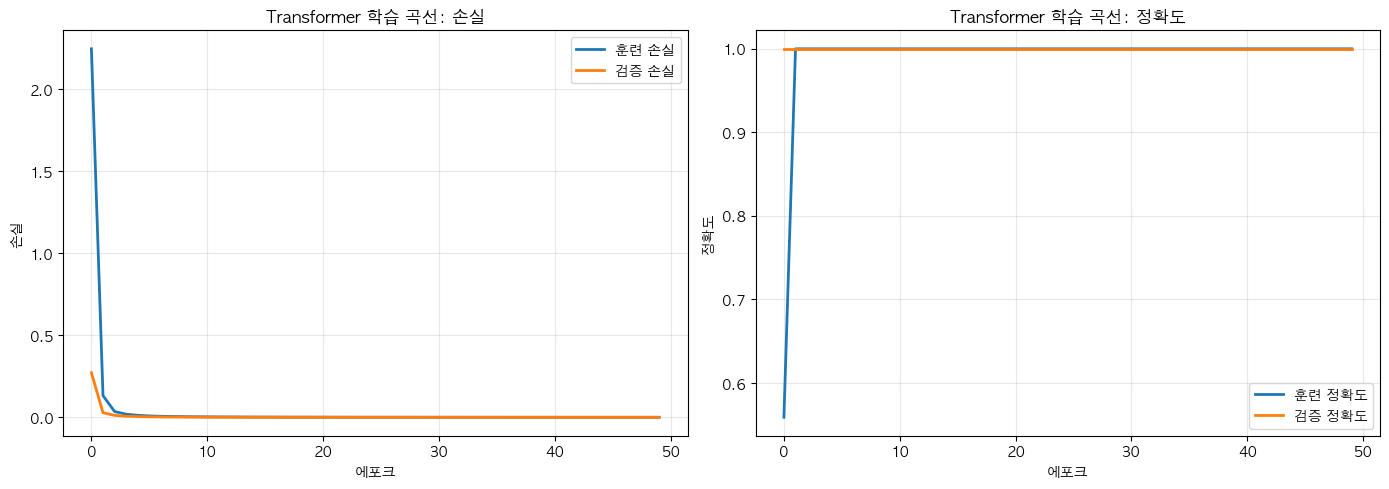

In [62]:
# 학습 곡선
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_transformer.history['loss'], label='훈련 손실', linewidth=2)
axes[0].plot(history_transformer.history['val_loss'], label='검증 손실', linewidth=2)
axes[0].set_xlabel('에포크')
axes[0].set_ylabel('손실')
axes[0].set_title('Transformer 학습 곡선: 손실')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_transformer.history['accuracy'], label='훈련 정확도', linewidth=2)
axes[1].plot(history_transformer.history['val_accuracy'], label='검증 정확도', linewidth=2)
axes[1].set_xlabel('에포크')
axes[1].set_ylabel('정확도')
axes[1].set_title('Transformer 학습 곡선: 정확도')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 14.3.3. 텍스트 생성 테스트

In [63]:
# 테스트 데이터 평가
test_loss_tf, test_acc_tf = transformer_model.evaluate(X_test_tf, y_test_tf, verbose=0)

print(f"테스트 손실: {test_loss_tf:.4f}")
print(f"테스트 정확도: {test_acc_tf:.4f} ({test_acc_tf*100:.2f}%)")

테스트 손실: 0.0000
테스트 정확도: 1.0000 (100.00%)


In [64]:
# 텍스트 생성 함수
def generate_text(seed_text, num_words=20, temperature=1.0):
    """
    주어진 시작 텍스트로부터 새로운 텍스트 생성
    
    temperature: 
    - 낮을수록 (0.5) 더 보수적/예측 가능한 텍스트
    - 높을수록 (1.5) 더 창의적/무작위적인 텍스트
    """
    seed_words = preprocess_text(seed_text).split()
    generated = seed_words.copy()
    
    for _ in range(num_words):
        # 마지막 SEQ_LENGTH 개의 단어를 입력으로 사용
        input_seq = generated[-SEQ_LENGTH:]
        
        # 패딩 (시퀀스가 짧은 경우)
        while len(input_seq) < SEQ_LENGTH:
            input_seq.insert(0, '<PAD>')
        
        # 단어를 인덱스로 변환
        input_idx = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in input_seq]
        input_idx = np.array([input_idx])
        
        # 예측
        predictions = transformer_model.predict(input_idx, verbose=0)[0]
        
        # Temperature sampling
        predictions = np.log(predictions + 1e-10) / temperature
        predictions = np.exp(predictions) / np.sum(np.exp(predictions))
        
        # 다음 단어 샘플링
        next_idx = np.random.choice(len(predictions), p=predictions)
        next_word = idx_to_word[next_idx]
        
        if next_word not in ['<PAD>', '<UNK>']:
            generated.append(next_word)
    
    return ' '.join(generated)

# 다양한 시작 문구로 텍스트 생성
seed_texts = [
    "the government announced",
    "scientists discovered",
    "technology companies",
    "economic growth"
]

print("="*80)
print("텍스트 생성 결과")
print("="*80)

for seed in seed_texts:
    print(f"\n시작 문구: '{seed}'")
    print("-" * 80)
    
    # 다양한 temperature로 생성
    for temp in [0.5, 1.0, 1.5]:
        generated = generate_text(seed, num_words=15, temperature=temp)
        print(f"Temperature {temp}: {generated}")
    print()

텍스트 생성 결과

시작 문구: 'the government announced'
--------------------------------------------------------------------------------
Temperature 0.5: the government announced leaders leaders leaders leaders leaders and innovation policies market announced announced in announced policies to
Temperature 0.5: the government announced leaders leaders leaders leaders leaders and innovation policies market announced announced in announced policies to
Temperature 1.0: the government announced leaders leaders leaders and innovation innovation development scientists in policies amid in interest research technology
Temperature 1.0: the government announced leaders leaders leaders and innovation innovation development scientists in policies amid in interest research technology
Temperature 1.5: the government announced leaders leaders innovation leaders innovation innovation reveals development scientists trade in in growth worldwide technology


시작 문구: 'scientists discovered'
---------------------------